In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import random
import pdb
import plotly.express as px
import plotly.graph_objects as go
import pickle
import scipy.io
from matplotlib.font_manager import FontProperties
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import matplotlib.animation as animation
import glob
from natsort import natsorted
from PIL import Image

def create_gif(pth, time_ind):
    #files = glob.glob(r"./imgs/*.png")
    files = glob.glob(os.path.join(pth,'*.png'))
    files = natsorted(files)
    image_array = []
    
    def update(i):
        im.set_array(image_array[i])
        return im, 
    
    for my_file in files:

        image = Image.open(my_file)
        image_array.append(image)
    
    # Create the figure and axes objects
    fig, ax = plt.subplots()

    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)
    
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=100, blit=True,repeat_delay=10,)

    # Show the animation
    #plt.show()

    #animation_fig.save("./imgs/animated_{}.gif".format(time_ind))
    animation_fig.save(os.path.join(pth,'animated_{}.gif').format(time_ind))
    pass

### Adding gamma_0 value for SINR computation ####

$\gamma = \frac{|h|_s^2P_t}{|h|_i^2P_t + N_0B}$

Assuming power transmitted power is same from all BSs then we have 

$\gamma = \frac{|h|_s^2}{|h|_i^2 + \frac{1}{\gamma_0}}$


where $\gamma_0 = P_t/N_0B$, you can assume P_t = 10 dBm, and the below calculations for $N_0$

In [2]:
## transmit power ###
Pt_dBm = 10  # Transmit power in dBm

#### Noise power ####
k = 1.38e-23  # Boltzmann's constant
T = 290       # Temperature in Kelvin
B = 10e6       # Bandwidth in Hz

# Calculate noise spectral density in Watts/Hz
Noise_spectral_density = k * T

# Convert noise spectral density to dBm/Hz
# Convert to Watts first then to dBm (1 mW = 0.001 W)
Noise_spectral_density_W = Noise_spectral_density * 1000  # Convert to mW
Noise_spectral_density_dBm = 10 * np.log10(Noise_spectral_density_W)
print('Noise_spectral_density_dBm', Noise_spectral_density_dBm)

# Calculate total noise power in Watts then convert to dBm
N_thermal = Noise_spectral_density * B  # Total noise power in Watts
N_thermal_dBm = 10 * np.log10(N_thermal * 1000)  # Convert noise power to dBm
print('thermal_noise_power(dBm)', N_thermal_dBm)

##### gamma_0 in dB ############
gamma_0_dB = Pt_dBm - N_thermal_dBm  # Calculate SNR in dB
#print('gamma_0 (dB)', gamma_0_dB)

##### gamma_0 ######
gamma_0 = np.power(10, gamma_0_dB/10)
print('1/gamma_0', 1/gamma_0)

Noise_spectral_density_dBm -173.97722915699805
thermal_noise_power(dBm) -103.97722915699808
1/gamma_0 4.001999999999999e-12


### 
CDF of SINR computed for F($\gamma$), for different channel realizations,
below is when the the device is at a mean distance of 1m from the serving BS with a standard deviation of 0.1 m, and mean distance from the interfering BS at 4 meters with std of 0.1m 

In [3]:
def return_cdf(a):
    sorted_a = np.sort(a)
    cdf = np.arange(1, len(sorted_a) + 1) / len(sorted_a)
    return sorted_a, cdf

In [4]:
############## Creating distances intra and inter ########
M = 5 # number of sub-networks 
Ts = 10000 # number of time slots
J = 5 # number of devices
f_c = 1.3 #GHz
TxRxds = np.zeros((Ts, M, M*J))
d_intra = np.abs(np.random.normal(0.5,0.1,M*J))
d_intra = np.reshape(d_intra, (M,J))

In [5]:
'''
for ts in range(Ts):
    d_inter_intra_arr = np.zeros((M, M*J))
    for cnt, m in enumerate(range(M)):
        d_inter = []
        #total_range = list(range(1, 21))
        for _ in range(M-1):
            d_mean = random.randint(2,20)
            #d_mean = random.choice(total_range)
            #total_range = [t for t in total_range if t!=d_mean]
            
            #d_mean = np.random.uniform(1,20)
            ds = np.abs(np.random.normal(d_mean, 0.1, J))
            d_inter.extend(ds)
        d_inter = np.array(d_inter)
        d_inter_intra = np.insert(d_inter, cnt*M, d_intra[m,:])
        #print(d_inter_intra)
        d_inter_intra_arr[m] = d_inter_intra
    TxRxds[ts] = d_inter_intra_arr
''';

In [6]:
def generate_random_point(grid_size):
    return np.random.uniform(0, grid_size, 2)

def generate_random_velocity():
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = 11.11  # 40 km/h in m/s
    return np.array([velocity * np.cos(angle), velocity * np.sin(angle)])

def is_within_grid(point, grid_size):
    return all(0 <= coord <= grid_size for coord in point)

def handle_boundary_collisions(point, grid_size):
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = 11.11
    if point[0] <= 0 or point[0] >= grid_size:
        angle = np.pi - angle if point[0] <= 0 else -angle
    if point[1] <= 0 or point[1] >= grid_size:
        angle = -np.pi / 2 - angle if point[1] <= 0 else np.pi / 2 - angle
    return np.array([velocity * np.cos(angle), velocity * np.sin(angle)])

def handle_ap_collisions(points, velocities, min_distance):
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            if np.linalg.norm(points[i] - points[j]) < min_distance:
                # Adjust direction randomly for both APs
                velocities[i] = generate_random_velocity()
                velocities[j] = generate_random_velocity()
    return velocities

def update_positions(points, velocities, tau, grid_size, min_distance):
    new_points = points + velocities * tau
    for i, point in enumerate(new_points):
        if not is_within_grid(point, grid_size):
            velocities[i] = handle_boundary_collisions(point, grid_size)
        new_points[i] = points[i] + velocities[i] * tau  # Recalculate with new velocity
    velocities = handle_ap_collisions(new_points, velocities, min_distance)
    return new_points, velocities

# Initialize parameters
grid_size = 20
num_points = M
min_distance = 2
tau = 0.01  # time interval in seconds

# Initialize points and velocities
points = np.array([generate_random_point(grid_size) for _ in range(num_points)])
velocities = np.array([generate_random_velocity() for _ in range(num_points)])
init_cents = points
# Simulation loop for 20 time steps
pth = r'C:\Users\sriniva3\OneDrive - Aalto University\Simulations\RL framework URLLC\RL framework_V2.0_DDPG\imgs'
#Ts = 1000
sub_net_cents = np.zeros((Ts+1, num_points, 2))
sub_net_cents[0] = init_cents
for step in tqdm(range(Ts-1)):
    points, velocities = update_positions(points, velocities, tau, grid_size, min_distance)
    sub_net_cents[step+1] = points
    '''
    # Plotting for visualization
    plt.figure(figsize=(3, 3))
    plt.scatter(points[:, 0], points[:, 1], c='red', label=f'Time Step {step+1}')
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.grid(True)
    plt.title(f'Access Points at Step {step+1}')
    plt.xlabel('Meters')
    plt.ylabel('Meters')
    #plt.legend()
    plt.savefig(os.path.join(pth, '{}.png'.format(step)))
    plt.close()
    #plt.show()
    ''';
#create_gif(pth, step)

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 12940.72it/s]


In [7]:
d_relative_locs = {}
for i in range(M):
    d_angle = np.random.uniform(0,2*np.pi,J) 
    d_r = np.random.uniform(0, 1, J)
    d_relative_locs[i] = np.vstack([d_r*np.cos(d_angle), d_r*np.sin(d_angle)])

In [8]:
def return_euclid_dist(device_x_coord, device_y_coord, AP_x_coord, AP_y_coord):
    device_coords = np.array([device_x_coord, device_y_coord])
    AP_coords = np.array([AP_x_coord, AP_y_coord])
    return np.linalg.norm(device_coords - AP_coords)

x_coords_ts, y_coords_ts = {}, {}
for ts in range(Ts):
    coords = sub_net_cents[ts]
    point_xs, point_ys = [], []
    for k in d_relative_locs.keys():
        point_x = d_relative_locs[k][0] + coords[k][0]
        point_y = d_relative_locs[k][1] + coords[k][1]
        #print(point_x, point_y)
        point_xs.append(point_x)
        point_ys.append(point_y)
    #break    
    x_coords_ts[ts] = point_xs
    y_coords_ts[ts] = point_ys

In [9]:
TxRxds = np.zeros((Ts, M, M*J))
for ts in range(Ts):
    device_x_coords, device_y_coords = np.array(x_coords_ts[ts]), np.array(y_coords_ts[ts])
    device_x_coords, device_y_coords = device_x_coords.flatten(), device_y_coords.flatten()
    AP_x_coords, AP_y_coords = sub_net_cents[ts][:,0], sub_net_cents[ts][:,1]
    
    #for dx in device_x_coords 
    dists = np.zeros((M,M*J))
    for i in range(AP_x_coords.shape[0]):
        dist = []
        for j in range(len(device_x_coords.flatten())):
            #dist = []
            #print(i,j)
            dist.append(return_euclid_dist(device_x_coords[j], device_y_coords[j], AP_x_coords[i], AP_y_coords[i]))
            #print(dist)
        dists[i] = np.array(dist)
    TxRxds[ts] = dists
    #break

#dist = return_euclid_dist(x_coords_ts[0], y_coords_ts[0], AP_x_coord, AP_y_coord)

In [10]:
all_SINRsdB, all_MeansPerSubNW, all_DiffsFromMean = np.zeros((Ts, M*J)), np.zeros((Ts, M)), np.zeros((Ts, M*J))
FadingGains_ts = []
for ts in range(Ts):
    
    ############ fast fading coeffecients ########
    FastFadingChannels = np.random.normal(0,1/np.sqrt(2), M*M*J) + 1j*np.random.normal(0,1/np.sqrt(2), M*M*J)
    #FastFadingChannels/=np.sqrt(2)
    FastFadingChannels = np.reshape(FastFadingChannels,(M,M*J))
    FadingGains = np.abs(FastFadingChannels)**2
    FadingGains_ts.append(FadingGains)
    #### path loss ####
    #alf, L0 = 2.55, 111.779
    #PathLossesdB = L0 + 10*alf*np.log10(TxRxds[ts]/1000)
    #PathGains = np.power(10, -PathLossesdB/10)
    
    PL_los = 31.84 +21.5*np.log10(TxRxds[ts]) + 19*np.log10(f_c)
    PL = 33+25.5*np.log10(TxRxds[ts])+20*np.log10(f_c)
    PL_nlos = np.max((PL_los, PL), axis = 0)
    PathGains = np.power(10, -PL_nlos/10)
    


    ##### Compute total path gains ########
    PathGainsTot = PathGains*FadingGains
    
    #### Compute WantedSigPerDev ######
    WantedSigPerDev = np.zeros((M,J))
    for m in range(M):
        wanted_sig = PathGainsTot[m,m*M:(m+1)*M]
        WantedSigPerDev[m] = wanted_sig

    #### Compute InterfPowsPerDev ######
    InterfPowsPerDev = np.zeros((M,J))
    for m in range(M):
        Interferers = [i for i in range(M) if i!=m]
        Devs = np.arange(m*M,(m+1)*M)
        #print(Interferers, Devs)
        InterfPowGains = PathGainsTot[np.ix_(Interferers, Devs)]
        InterfPowsPerDev[m,] = np.sum(InterfPowGains, axis = 0)
        #break

    
    SINRs = WantedSigPerDev/(InterfPowsPerDev + 1/gamma_0);
    SINRsdB = 10*np.log10(SINRs)
    MeansPerSubNW = np.mean(SINRsdB, axis = 1)
    
    DiffsFromMean = []
    for i in range(len(MeansPerSubNW)):
        diff = SINRsdB[i] - MeansPerSubNW[i]
        DiffsFromMean.append(diff)
    DiffsFromMean = np.array(DiffsFromMean)    
    
    all_SINRsdB[ts,:] = SINRsdB.flatten()
    all_MeansPerSubNW[ts,:] = MeansPerSubNW.flatten()
    all_DiffsFromMean[ts,:] = DiffsFromMean.flatten()
    
    #break

In [11]:
all_DiffsFromMean.flatten().shape

(250000,)

25.475525654323096 25.475525654323107 -1.326583287664107e-17


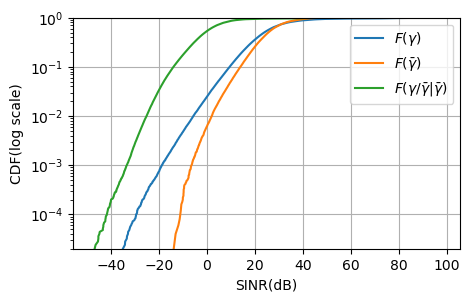

In [12]:
a1, cdf1 = return_cdf(all_SINRsdB.flatten())
a2, cdf2 = return_cdf(all_MeansPerSubNW.flatten())
a3, cdf3 = return_cdf(all_DiffsFromMean.flatten())
plt.figure(figsize= [5,3])
plt.ylim(np.min(cdf2))
plt.semilogy(a1, cdf1, label = r'$F(\gamma)$')
plt.semilogy(a2, cdf2 , label = r'$F(\bar{\gamma})$')
plt.semilogy(a3, cdf3, label =  r'$F(\gamma/\bar{\gamma}|\bar{\gamma})$')
plt.grid()
plt.xlabel('SINR(dB)')
plt.ylabel('CDF(log scale)')
plt.legend()
print(np.mean(all_SINRsdB.flatten()), np.mean(all_MeansPerSubNW.flatten()), np.mean(all_DiffsFromMean.flatten()))

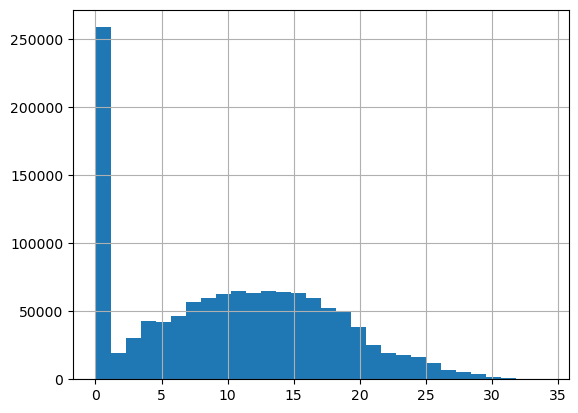

In [13]:
plt.hist(TxRxds.flatten(), bins = 30)
plt.grid()
plt.show()

### Using Jakes model 

In [16]:

def return_jakes_coeffcients(fd_max, TimeVaris, n_links = 5, plot = True):
    ff_gains, TimeSequences = [], []
    rays = 100
    for i in tqdm(range(n_links)):    
        #TimeVaris = np.arange(0,50,0.0005)
        #TimeVaris = np.arange(0,.2,0.005)
        frequs = np.sort(np.array([np.round(fd_max*np.cos(2*np.pi*np.random.uniform(0,1))) for _ in range(rays)]))
        phases = np.array([np.exp(1j*2*np.pi*np.random.uniform(0,1)) for _ in range(rays)])

        TimeSequence = []
        for t in TimeVaris:
            tab = np.exp(1j*2*np.pi*frequs*t)
            tabrot = tab*phases
            fun = np.sum(tabrot)
            TimeSequence.append(fun)
        TimeSequence = np.array(TimeSequence)

        #TimeSequence = TimeSequence/np.linalg.norm(TimeSequence)*np.sqrt(len(TimeSequence))
        PowerSequence1 =  np.abs(TimeSequence)**2;
        #plt.plot(TimeVaris[0:200], 10*np.log10(PowerSequence1)[0:200])
        ff_gains.append(PowerSequence1)
        TimeSequences.append(TimeSequence)
    ff_gains = np.array(ff_gains)/rays
    TimeSequences = np.array(TimeSequences)
    if plot:
        plt.plot(TimeVaris[0:200], 10*np.log10(ff_gains[0])[0:200])
        plt.show()
    return ff_gains, TimeSequences

v = 40 #kmph 
v_ms = v*5/18
c = 3*1e8
tau = .01
fd_max = v_ms*f_c*1e9/c
TimeVaris = np.arange(0,5,0.0005)

ff_gains, TimeSequences = return_jakes_coeffcients(fd_max, TimeVaris, n_links = 100, plot = False)
#plt.plot(TimeVaris[0:Ts], 10*np.log10(ff_gains.flatten()[0:Ts]))
#plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


In [17]:
############ fast fading coeffecients ########
FastFadingChannels = np.random.normal(0,1/np.sqrt(2), M*J) + 1j*np.random.normal(0,1/np.sqrt(2), M*J)
FastFadingChannels = np.reshape(FastFadingChannels,(M,J))
FadingGains = np.abs(FastFadingChannels)**2
all_SINRsdB, all_MeansPerSubNW, all_DiffsFromMean = np.zeros((Ts, M*J)), np.zeros((Ts, M)), np.zeros((Ts, M*J))
for ts in range(Ts):
    

    #FadingGains.shape

    all_fast_fading_gains = np.zeros((M,M*J))
    for m in range(M):
        jakes_coeffs = ff_gains[:,ts]
        jakes_coeffs = np.reshape(jakes_coeffs,(M,(M-1)*J))
        all_fast_fading_gains[m] = np.concatenate([FadingGains[m], jakes_coeffs[m]])
    all_fast_fading_gains = np.array(all_fast_fading_gains)
    #### path loss ####
    #alf, L0 = 2.55, 111.779
    #PathLossesdB = L0 + 10*alf*np.log10(TxRxds[ts]/1000)
    #PathGains = np.power(10, -PathLossesdB/10)
    
    PL_los = 31.84 +21.5*np.log10(TxRxds[ts]) + 19*np.log10(f_c)
    PL = 33+25.5*np.log10(TxRxds[ts])+20*np.log10(f_c)
    PL_nlos = np.max((PL_los, PL), axis = 0)
    PathGains = np.power(10, -PL_nlos/10)
    


    ##### Compute total path gains ########
    PathGainsTot = PathGains*all_fast_fading_gains
    
    #### Compute WantedSigPerDev ######
    WantedSigPerDev = np.zeros((M,J))
    for m in range(M):
        wanted_sig = PathGainsTot[m,m*M:(m+1)*M]
        WantedSigPerDev[m] = wanted_sig

    #### Compute InterfPowsPerDev ######
    InterfPowsPerDev = np.zeros((M,J))
    for m in range(M):
        Interferers = [i for i in range(M) if i!=m]
        Devs = np.arange(m*M,(m+1)*M)
        #print(Interferers, Devs)
        InterfPowGains = PathGainsTot[np.ix_(Interferers, Devs)]
        InterfPowsPerDev[m,] = np.sum(InterfPowGains, axis = 0)
        #break

    
    SINRs = WantedSigPerDev/(InterfPowsPerDev + 1/gamma_0);
    SINRsdB = 10*np.log10(SINRs)
    MeansPerSubNW = np.mean(SINRsdB, axis = 1)
    
    DiffsFromMean = []
    for i in range(len(MeansPerSubNW)):
        diff = SINRsdB[i] - MeansPerSubNW[i]
        DiffsFromMean.append(diff)
    DiffsFromMean = np.array(DiffsFromMean)    
    
    all_SINRsdB[ts,:] = SINRsdB.flatten()
    all_MeansPerSubNW[ts,:] = MeansPerSubNW.flatten()
    all_DiffsFromMean[ts,:] = DiffsFromMean.flatten()
    
    #break

25.95005617108837 25.950056171088367 -7.87281351222191e-18


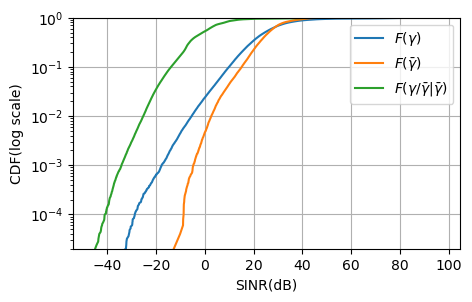

In [18]:
a1, cdf1 = return_cdf(all_SINRsdB.flatten())
a2, cdf2 = return_cdf(all_MeansPerSubNW.flatten())
a3, cdf3 = return_cdf(all_DiffsFromMean.flatten())
plt.figure(figsize= [5,3])
plt.ylim(np.min(cdf2))
plt.semilogy(a1, cdf1, label = r'$F(\gamma)$')
plt.semilogy(a2, cdf2 , label = r'$F(\bar{\gamma})$')
plt.semilogy(a3, cdf3, label =  r'$F(\gamma/\bar{\gamma}|\bar{\gamma})$')
plt.grid()
plt.xlabel('SINR(dB)')
plt.ylabel('CDF(log scale)')
plt.legend()
print(np.mean(all_SINRsdB.flatten()), np.mean(all_MeansPerSubNW.flatten()), np.mean(all_DiffsFromMean.flatten()))

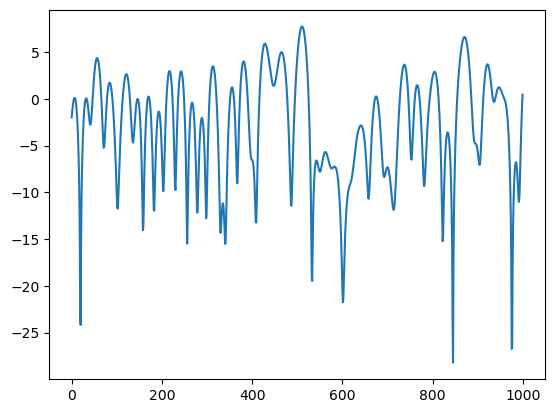

In [22]:
plt.plot(10*np.log10(ff_gains[0].flatten()[0:1000]))
plt.show()

In [ ]:
'''
path = 'C:\\Users\\sriniva3\\OneDrive - Aalto University\\Simulations\\RL framework URLLC\\Post_ICC2024_results'
sinr_data_before_resource_schdule = {}
sinr_data_before_resource_schdule['all_SINRsdB']  = all_SINRsdB.flatten()
sinr_data_before_resource_schdule['all_MeansPerSubNW']  = all_MeansPerSubNW.flatten()
sinr_data_before_resource_schdule['all_DiffsFromMean']  = all_DiffsFromMean.flatten()
with open(os.path.join(path,'sinr_data_before_resource_schdule.pickle'), 'wb') as handle:
    pickle.dump(sinr_data_before_resource_schdule, handle, protocol=pickle.HIGHEST_PROTOCOL)
''';

In [ ]:
############### Across N sub channels with universal frequency reuse 1 ###########
N = 30
all_SINRsdB, all_MeansPerSubNW, all_DiffsFromMean = np.zeros((Ts, M*J*N)), np.zeros((Ts, M)), np.zeros((Ts, M*J*N))
for ts in range(Ts):
    
    FastFadingChannels = np.random.normal(0,1/np.sqrt(2), M*M*J*N) + 1j*np.random.normal(0,1/np.sqrt(2), M*M*J*N)
    #FastFadingChannels = np.random.normal(0,1/np.sqrt(2), M*M*J) + 1j*np.random.normal(0,1/np.sqrt(2), M*M*J)
    #FastFadingChannels = np.tile(FastFadingChannels, (N, 1, 1))
    #FastFadingChannels/=np.sqrt(2)
    FastFadingChannels = np.reshape(FastFadingChannels,(N,M,M*J))
    FadingGains = np.abs(FastFadingChannels)**2
    #### path loss ####
    #alf, L0 = 2.55, 111.779
    #PathLossesdB = L0 + 10*alf*np.log10(TxRxds[ts]/1000)
    #PathGains = np.power(10, -PathLossesdB/10)
    TxRxd = TxRxds[ts]
    TxRxd = np.tile(TxRxd, (N, 1, 1))
    
    PL_los = 31.84 +21.5*np.log10(TxRxd) + 19*np.log10(f_c)
    PL = 33+25.5*np.log10(TxRxd)+20*np.log10(f_c)
    PL_nlos = np.max((PL_los, PL), axis = 0)
    PathGains = np.power(10, -PL_nlos/10)
    


    ##### Compute total path gains ########
    PathGainsTots = PathGains*FadingGains
    SINRs_all_channels = []
    for n in range(N):
        PathGainsTot = PathGainsTots[n]
        #### Compute WantedSigPerDev ######
        WantedSigPerDev = np.zeros((M,J))
        for m in range(M):
            wanted_sig = PathGainsTot[m,m*M:(m+1)*M]
            WantedSigPerDev[m] = wanted_sig

        #### Compute InterfPowsPerDev ######
        InterfPowsPerDev = np.zeros((M,J))
        for m in range(M):
            Interferers = [i for i in range(M) if i!=m]
            Devs = np.arange(m*M,(m+1)*M)
            #print(Interferers, Devs)
            InterfPowGains = PathGainsTot[np.ix_(Interferers, Devs)]
            InterfPowsPerDev[m,] = np.sum(InterfPowGains, axis = 0)
            #break


        SINRs = WantedSigPerDev/(InterfPowsPerDev + 1/gamma_0);
        #SINRsdB = 10*np.log10(SINRs)
        SINRs_all_channels.append(SINRs)
    SINRs_all_channels = np.array(SINRs_all_channels)
    #SINRs_all_channels = np.mean(SINRs_all_channels, axis = 0)
    SINRsdB = 10*np.log10(SINRs_all_channels)
    #MeansPerSubNW = np.mean(SINRsdB, axis = 1)
    SINRsdB = np.transpose(SINRsdB, (1, 0, 2))
    MeansPerSubNW = np.array([np.mean(SINRsdB[i].flatten()) for i in range(SINRsdB.shape[0])])
    DiffsFromMean = []
    for i in range(len(MeansPerSubNW)):
        diff = SINRsdB[i] - MeansPerSubNW[i]
        DiffsFromMean.append(diff)
    DiffsFromMean = np.array(DiffsFromMean)  
    all_SINRsdB[ts,:] = SINRsdB.flatten()
    all_MeansPerSubNW[ts,:] = MeansPerSubNW.flatten()
    all_DiffsFromMean[ts,:] = DiffsFromMean.flatten()
    
    #break

In [ ]:
a1, cdf1 = return_cdf(all_SINRsdB.flatten())
a2, cdf2 = return_cdf(all_MeansPerSubNW.flatten())
a3, cdf3 = return_cdf(all_DiffsFromMean.flatten())

plt.ylim(np.min(cdf2))
plt.semilogy(a1, cdf1, label = r'$F(\gamma)$')
plt.semilogy(a2, cdf2 , label = r'$F(\bar{\gamma})$')
plt.semilogy(a3, cdf3, label =  r'$F(\gamma/\bar{\gamma}|\bar{\gamma})$')
plt.grid()
plt.xlabel('SINR(dB)')
plt.ylabel('CDF(log scale)')
plt.legend()
print(np.mean(all_SINRsdB.flatten()), np.mean(all_MeansPerSubNW.flatten()), np.mean(all_DiffsFromMean.flatten()))